<a href="https://colab.research.google.com/github/OttoJursch/DRL_robot_exploration/blob/master/eval_reward_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install pybind11
!git clone https://github.com/pybind/pybind11.git
!cd pybind11 && mkdir build && cd build && cmake .. && make install

#Install Eigen
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen

# Install dependencies on colab
!git clone https://github.com/OttoJursch/DRL_robot_exploration.git

#Build the C++/pybind stuff
!rm -rf DRL_robot_exploration/build
!cd DRL_robot_exploration && mkdir build && cd build && cmake .. && make

Cloning into 'pybind11'...
remote: Enumerating objects: 13933, done.
remote: Total 13933 (delta 0), reused 0 (delta 0), pack-reused 13933
Receiving objects: 100% (13933/13933), 5.40 MiB | 7.73 MiB/s, done.
Resolving deltas: 100% (9484/9484), done.
-- The CXX compiler identification is GNU 7.5.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- pybind11 v2.6.2 dev1
-- CMake 3.12.0
-- Found PythonInterp: /usr/bin/python3.6 (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- PYTHON 3.6.9
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- pybind11::lto enabled
-- pybind11::thin_lto enabled
-- Setting tests build type to MinSizeRel as none was specified
-- Building tests WITHOUT Eigen, use -DDOWNLOAD_EIGEN on CMake 3.11+ to dow

In [1]:
from scipy import spatial
from skimage import io
import numpy as np
import numpy.ma as ma
import time
import sys
from scipy import ndimage
import matplotlib.pyplot as plt

sys.path.append('DRL_robot_exploration')
from build.inverse_sensor_model import *
from build.astar import *
from random import shuffle
import random
import os
np.random.seed(1000)
random.seed(1000)


from copy import deepcopy

class PaperRewardFunction:
    '''
    Reward function from the paper
    '''
    def __init__(self):
        pass

    def get_reward(self, robot_position, old_op_map, op_map, coll_index):
        '''
        Takes in map before step and map after step. Measures effect of sensor
        input from last step
        '''
        if not coll_index:
            reward = float(
                np.size(np.where(op_map == 255)) - np.size(np.where(old_op_map == 255))) / 14000
            if reward > 1:
                reward = 1
        else:
            reward = -1
        return reward

class FrontierRewardFunction:
    def __init__(self, reward_scale):
        self.reward_scale = reward_scale
        self.paper_reward = PaperRewardFunction()

    def frontiers(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)),
                             'constant',
                             constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]

        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x)
        y = np.linspace(0, map_y - 1, map_y)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def astar_path(self, weights, start, goal, allow_diagonal=True):
        temp_start = [start[1], start[0]]
        temp_goal = [goal[1], goal[0]]
        temp_weight = (weights < 150) * 254 + 1
        # For the heuristic to be valid, each move must cost at least 1.
        if temp_weight.min(axis=None) < 1.:
            raise ValueError("Minimum cost to move must be 1, but got %f" % (
                temp_weight.min(axis=None)))
        # Ensure start is within bounds.
        if (temp_start[0] < 0 or temp_start[0] >= temp_weight.shape[0] or
                temp_start[1] < 0 or temp_start[1] >= temp_weight.shape[1]):
            raise ValueError("Start lies outside grid.")
        # Ensure goal is within bounds.
        if (temp_goal[0] < 0 or temp_goal[0] >= temp_weight.shape[0] or
                temp_goal[1] < 0 or temp_goal[1] >= temp_weight.shape[1]):
            raise ValueError("Goal of lies outside grid.")

        height, width = temp_weight.shape
        start_idx = np.ravel_multi_index(temp_start, (height, width))
        goal_idx = np.ravel_multi_index(temp_goal, (height, width))

        path = astar(
            temp_weight.flatten(), height, width, start_idx, goal_idx, allow_diagonal,
        )
        return path

    def get_reward(self, robot_pos, old_op_map, op_map, coll_index):
        paper_reward = self.paper_reward.get_reward(robot_pos, old_op_map,
                                                    op_map, coll_index)
        


        #If there was a collision return the collision reward
        if coll_index:
            print('collided??')
            return paper_reward

        frontiers = np.array(
            self.frontiers(op_map, op_map.shape, self.map_points(op_map)))
        
        min_frontier_point = np.argmin(np.linalg.norm(robot_pos - frontiers, axis=1))
        min_frontier = frontiers[min_frontier_point, :]
        print('frontier shape', min_frontier)

        min_frontier[0] = np.clip(min_frontier[0], 0, 640)
        min_frontier[1] = np.clip(min_frontier[1], 0, 480)

        path = self.astar_path(op_map, robot_pos, min_frontier)
        
        min_frontier_dist = 0
        last_point = path[0]
        for point in path[1:]:
          min_frontier_dist += np.linalg.norm(point - last_point)

        #min_frontier_dist = -np.min(np.linalg.norm(robot_pos - frontiers, axis=1))
        #print('min_frontier_dist', min_frontier_dist)
        #print('paper reward', paper_reward)
        return -self.reward_scale * min_frontier_dist - (1 - paper_reward)

frontier_reward = FrontierRewardFunction(1/14000)

class Robot:
    def __init__(self, index_map, train, plot):
        self.mode = train
        self.plot = plot
        if self.mode:
            self.map_dir = 'DRL_robot_exploration/DungeonMaps/train'
        else:
            self.map_dir = 'DRL_robot_exploration/DungeonMaps/test'
        self.map_list = os.listdir(self.map_dir)
        self.map_number = np.size(self.map_list)
        if self.mode:
            shuffle(self.map_list)
        self.li_map = index_map
        self.global_map, self.robot_position = self.map_setup(self.map_dir + '/' + self.map_list[self.li_map])
        self.op_map = np.ones(self.global_map.shape) * 127
        self.map_size = np.shape(self.global_map)
        self.finish_percent = 0.985
        self.rewards = []
        self.resolution = 1
        self.sensor_range = 80
        self.old_position = np.zeros([2])
        self.old_op_map = np.empty([0])
        self.action_space = np.genfromtxt('DRL_robot_exploration/scripts/action_points.csv', delimiter=",")
        self.t = self.map_points(self.global_map)
        self.free_tree = spatial.KDTree(self.free_points(self.global_map).tolist())
        self.robot_size = 6
        self.local_size = 40
        if self.plot:
            self.xPoint = np.array([self.robot_position[0]])
            self.yPoint = np.array([self.robot_position[1]])
            self.x2frontier = np.empty([0])
            self.y2frontier = np.empty([0])

    def begin(self):
        self.op_map = self.inverse_sensor(self.robot_position, self.sensor_range, self.op_map, self.global_map)
        step_map = self.robot_model(self.robot_position, self.robot_size, self.t, self.op_map)
        map_local = self.local_map(self.robot_position, step_map, self.map_size, self.sensor_range + self.local_size)
        if self.plot:
            self.plot_env()
        return map_local

    def step(self, action_index):
        terminal = False
        complete = False
        new_location = False
        all_map = False
        self.old_position = self.robot_position.copy()
        self.old_op_map = self.op_map.copy()

        # take action
        self.take_action(action_index, self.robot_position)

        # collision check
        collision_points, collision_index = self.collision_check(self.old_position, self.robot_position, self.map_size,
                                                                 self.global_map)

        if collision_index:
            self.robot_position = self.nearest_free(self.free_tree, collision_points)
            self.op_map = self.inverse_sensor(self.robot_position, self.sensor_range, self.op_map, self.global_map)
            step_map = self.robot_model(self.robot_position, self.robot_size, self.t, self.op_map)
        else:
            self.op_map = self.inverse_sensor(self.robot_position, self.sensor_range, self.op_map, self.global_map)
            step_map = self.robot_model(self.robot_position, self.robot_size, self.t, self.op_map)

        map_local = self.local_map(self.robot_position, step_map, self.map_size, self.sensor_range + self.local_size)
        reward = self.get_reward(self.old_op_map, self.op_map, collision_index)
        self.rewards.append(frontier_reward.get_reward(self.robot_position, self.old_op_map, self.op_map, collision_index))

        if reward <= 0.02 and not collision_index:
            reward = -0.8
            new_location = True
            terminal = True

        # during training, the robot is relocated if it has a collision
        # during testing, the robot will use collision check to avoid the collision
        if collision_index:
            if not self.mode:
                new_location = False
                terminal = False
            else:
                new_location = True
                terminal = True
            if self.plot and self.mode:
                self.xPoint = ma.append(self.xPoint, self.robot_position[0])
                self.yPoint = ma.append(self.yPoint, self.robot_position[1])
                self.plot_env()
            self.robot_position = self.old_position.copy()
            self.op_map = self.old_op_map.copy()
            if self.plot and self.mode:
                self.xPoint[self.xPoint.size-1] = ma.masked
                self.yPoint[self.yPoint.size-1] = ma.masked
        else:
            if self.plot:
                self.xPoint = ma.append(self.xPoint, self.robot_position[0])
                self.yPoint = ma.append(self.yPoint, self.robot_position[1])
                self.plot_env()

        # check if exploration is finished
        if np.size(np.where(self.op_map == 255))/np.size(np.where(self.global_map == 255)) > self.finish_percent:
            self.li_map += 1
            if self.li_map == self.map_number:
                self.li_map = 0
                all_map = True
            #self.__init__(self.li_map, self.mode, self.plot)
            complete = True
            new_location = False
            terminal = True

        return map_local, reward, terminal, complete, new_location, collision_index, all_map

    def rescuer(self):
        complete = False
        all_map = False
        pre_position = self.robot_position.copy()
        self.robot_position = self.frontier(self.op_map, self.map_size, self.t)
        self.op_map = self.inverse_sensor(self.robot_position, self.sensor_range, self.op_map, self.global_map)
        step_map = self.robot_model(self.robot_position, self.robot_size, self.t, self.op_map)
        map_local = self.local_map(self.robot_position, step_map, self.map_size, self.sensor_range + self.local_size)

        if self.plot:
            path = self.astar_path(self.op_map, pre_position.tolist(), self.robot_position.tolist())
            print(path.shape)

            for col in range(path.shape[1]):
              self.rewards.append(frontier_reward.get_reward(path[:, col], self.op_map, self.op_map, False))

            self.x2frontier = ma.append(self.x2frontier, ma.masked)
            self.y2frontier = ma.append(self.y2frontier, ma.masked)
            self.x2frontier = ma.append(self.x2frontier, path[1, :])
            self.y2frontier = ma.append(self.y2frontier, path[0, :])
            self.xPoint = ma.append(self.xPoint, ma.masked)
            self.yPoint = ma.append(self.yPoint, ma.masked)
            self.xPoint = ma.append(self.xPoint, self.robot_position[0])
            self.yPoint = ma.append(self.yPoint, self.robot_position[1])
            print('rewards', self.rewards)
            self.plot_env()

        if np.size(np.where(self.op_map == 255))/np.size(np.where(self.global_map == 255)) > self.finish_percent:
            self.li_map += 1
            if self.li_map == self.map_number:
                self.li_map = 0
                all_map = True
            #self.__init__(self.li_map, self.mode, self.plot)
            complete = True
            new_location = False
            terminal = True
        return map_local, complete, all_map

    def take_action(self, action_index, robot_position):
        move_action = self.action_space[action_index, :]
        robot_position[0] = np.round(robot_position[0] + move_action[0])
        robot_position[1] = np.round(robot_position[1] + move_action[1])

    def map_setup(self, location):
        global_map = (io.imread(location, 1) * 255).astype(int)
        robot_location = np.nonzero(global_map == 208)
        robot_location = np.array([np.array(robot_location)[1, 127], np.array(robot_location)[0, 127]])
        global_map = (global_map > 150)
        global_map = global_map * 254 + 1
        return global_map, robot_location

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x)
        y = np.linspace(0, map_y - 1, map_y)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def local_map(self, robot_location, map_glo, map_size, local_size):
        minX = robot_location[0] - local_size
        maxX = robot_location[0] + local_size
        minY = robot_location[1] - local_size
        maxY = robot_location[1] + local_size

        if minX < 0:
            maxX = abs(minX) + maxX
            minX = 0
        if maxX > map_size[1]:
            minX = minX - (maxX - map_size[1])
            maxX = map_size[1]
        if minY < 0:
            maxY = abs(minY) + maxY
            minY = 0
        if maxY > map_size[0]:
            minY = minY - (maxY - map_size[0])
            maxY = map_size[0]

        map_loc = map_glo[minY:maxY][:, minX:maxX]
        return map_loc

    def free_points(self, op_map):
        index = np.where(op_map == 255)
        free = np.asarray([index[1], index[0]]).T
        return free

    def get_reward(self, old_op_map, op_map, coll_index):
        if not coll_index:
            reward = float(np.size(np.where(op_map == 255)) - np.size(np.where(old_op_map == 255))) / 14000
            if reward > 1:
                reward = 1
        else:
            reward = -1
        return reward

    def nearest_free(self, tree, point):
        pts = np.atleast_2d(point)
        index = tuple(tree.query(pts)[1])
        nearest = tree.data[index]
        return nearest

    def robot_model(self, position, robot_size, points, map_glo):
        map_copy = map_glo.copy()
        robot_points = self.range_search(position, robot_size, points)
        for i in range(0, robot_points.shape[0]):
            rob_loc = np.int32(robot_points[i, :])
            rob_loc = np.flipud(rob_loc)
            map_copy[tuple(rob_loc)] = 76
        map_with_robot = map_copy
        return map_with_robot

    def range_search(self, position, r, points):
        nvar = position.shape[0]
        r2 = r ** 2
        s = 0
        for d in range(0, nvar):
            s += (points[:, d] - position[d]) ** 2
        idx = np.nonzero(s <= r2)
        idx = np.asarray(idx).ravel()
        inrange_points = points[idx, :]
        return inrange_points

    def collision_check(self, start_point, end_point, map_size, map_glo):
        x0, y0 = start_point.round()
        x1, y1 = end_point.round()
        dx, dy = abs(x1 - x0), abs(y1 - y0)
        x, y = x0, y0
        error = dx - dy
        x_inc = 1 if x1 > x0 else -1
        y_inc = 1 if y1 > y0 else -1
        dx *= 2
        dy *= 2

        coll_points = np.ones((1, 2), np.uint8) * -1

        while 0 <= x < map_size[1] and 0 <= y < map_size[0]:
            k = map_glo.item(y, x)
            if k == 1:
                coll_points.itemset((0, 0), x)
                coll_points.itemset((0, 1), y)
                break

            if x == end_point[0] and y == end_point[1]:
                break

            if error > 0:
                x += x_inc
                error -= dy
            else:
                y += y_inc
                error += dx
        if np.sum(coll_points) == -2:
            coll_index = False
        else:
            coll_index = True

        return coll_points, coll_index

    def inverse_sensor(self, robot_position, sensor_range, op_map, map_glo):
        op_map = inverse_sensor_model(robot_position[0], robot_position[1], sensor_range, op_map, map_glo)
        return op_map

    def frontier(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)), 'constant', constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]
        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f[0]

    def unique_rows(self, a):
        a = np.ascontiguousarray(a)
        unique_a = np.unique(a.view([('', a.dtype)] * a.shape[1]))
        result = unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))
        result = result[~np.isnan(result).any(axis=1)]
        return result

    def astar_path(self, weights, start, goal, allow_diagonal=True):
        temp_start = [start[1], start[0]]
        temp_goal = [goal[1], goal[0]]
        temp_weight = (weights < 150) * 254 + 1
        # For the heuristic to be valid, each move must cost at least 1.
        if temp_weight.min(axis=None) < 1.:
            raise ValueError("Minimum cost to move must be 1, but got %f" % (
                temp_weight.min(axis=None)))
        # Ensure start is within bounds.
        if (temp_start[0] < 0 or temp_start[0] >= temp_weight.shape[0] or
                temp_start[1] < 0 or temp_start[1] >= temp_weight.shape[1]):
            raise ValueError("Start lies outside grid.")
        # Ensure goal is within bounds.
        if (temp_goal[0] < 0 or temp_goal[0] >= temp_weight.shape[0] or
                temp_goal[1] < 0 or temp_goal[1] >= temp_weight.shape[1]):
            raise ValueError("Goal of lies outside grid.")

        height, width = temp_weight.shape
        start_idx = np.ravel_multi_index(temp_start, (height, width))
        goal_idx = np.ravel_multi_index(temp_goal, (height, width))

        path = astar(
            temp_weight.flatten(), height, width, start_idx, goal_idx, allow_diagonal,
        )
        return path

    def plot_env(self):
        plt.cla()
        plt.imshow(self.op_map, cmap='gray')
        plt.axis((0, self.map_size[1], self.map_size[0], 0))
        plt.plot(self.xPoint, self.yPoint, 'b', linewidth=2)
        plt.plot(self.x2frontier, self.y2frontier, 'r', linewidth=2)
        plt.plot(self.robot_position[0], self.robot_position[1], 'mo', markersize=8)
        plt.plot(self.xPoint[0], self.yPoint[0], 'co', markersize=8)
        plt.pause(0.05)

In [2]:
import sys
sys.path.append('DRL_robot_exploration')
import os
import tensorflow as tf
from skimage.transform import resize
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

def weight_variable(shape):
    initial = tf.compat.v1.random.truncated_normal(shape, stddev=0.01)
    return tf.compat.v1.Variable(initial)


def bias_variable(shape):
    initial = tf.compat.v1.constant(0.01, shape=shape)
    return tf.compat.v1.Variable(initial)


def conv2d(x, W, stride):
    return tf.compat.v1.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding="VALID")

class experience_buffer():
    def __init__(self, buffer_size=1000):
        self.buffer = []
        self.buffer_size = buffer_size

    def add(self, experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1 + len(self.buffer)) - self.buffer_size] = []
        self.buffer.append(experience)

    def sample(self, batch_size, trace_length):
        sampled_episodes = random.sample(self.buffer, batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0, len(episode) + 1 - trace_length)
            sampledTraces.append(episode[point:point + trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces, [batch_size * trace_length, 5])


def padd_eps(eps_buff):
    if len(eps_buff) < trace_length:
        s = np.zeros([1, 84, 84, 1])
        a = np.zeros([ACTIONS])
        r = 0
        s1 = np.zeros([1, 84, 84, 1])
        d = True
        for i in range(0, trace_length - len(eps_buff)):
            eps_buff.append(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))
    return eps_buff


def copy_weights(sess):
    trainable = tf.compat.v1.trainable_variables()
    for i in range(len(trainable) // 2):
        assign_op = trainable[i + len(trainable) // 2].assign(trainable[i])
        sess.run(assign_op)



def create_LSTM(num_action, num_cell, scope):
    # network weights
    W_conv1 = weight_variable([8, 8, 1, 32])
    b_conv1 = bias_variable([32])
    W_conv2 = weight_variable([4, 4, 32, 64])
    b_conv2 = bias_variable([64])
    W_conv3 = weight_variable([3, 3, 64, 64])
    b_conv3 = bias_variable([64])
    W_conv4 = weight_variable([7, 7, 64, 512])
    b_conv4 = bias_variable([512])
    W_fc2 = weight_variable([512, num_action])
    b_fc2 = bias_variable([num_action])

    # training setup
    trainLength = tf.compat.v1.placeholder(shape=None, dtype=tf.int32)

    # input layer
    s = tf.compat.v1.placeholder("float", [None, 84, 84, 1])
    batch_size = tf.compat.v1.placeholder(dtype=tf.int32, shape=[])

    # hidden layers
    h_conv1 = tf.compat.v1.nn.relu(conv2d(s, W_conv1, 4) + b_conv1)
    h_conv2 = tf.compat.v1.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)
    h_conv3 = tf.compat.v1.nn.relu(conv2d(h_conv2, W_conv3, 1) + b_conv3)
    h_conv4 = tf.compat.v1.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

    # define rnn layer
    rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(
        num_units=num_cell, state_is_tuple=True)
    convFlat = tf.reshape(tf.compat.v1.layers.flatten(
        h_conv4), [batch_size, trainLength, num_cell])
    state_in = rnn_cell.zero_state(batch_size, tf.float32)
    rnn, rnn_state = tf.compat.v1.nn.dynamic_rnn(
        inputs=convFlat, cell=rnn_cell, dtype=tf.float32, initial_state=state_in, scope=scope)
    rnn = tf.reshape(rnn, shape=[-1, num_cell])

    keep_rate = tf.compat.v1.placeholder(shape=None, dtype=tf.float32)
    hidden = tf.compat.v1.nn.dropout(rnn, keep_rate)

    # readout layer
    readout = tf.matmul(hidden, W_fc2) + b_fc2

    return s, readout, keep_rate, trainLength, batch_size, state_in, rnn_state


# select mode
TRAIN = False
PLOT = True

# training environment parameters
ACTIONS = 50  # number of valid actions
GAMMA = 0.99  # decay rate of past observations
OBSERVE = 1e4  # timesteps to observe before training
EXPLORE = 2e6  # frames over which to anneal epsilon
REPLAY_MEMORY = 1000  # number of previous transitions to remember
BATCH = 8  # size of minibatch
h_size = 512  # size of hidden cells of LSTM
trace_length = 8  # memory length
FINAL_RATE = 0  # final value of dropout rate
INITIAL_RATE = 0.9  # initial value of dropout rate
TARGET_UPDATE = 25000  # update frequency of the target network


def start():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.InteractiveSession(config=config)
    s, readout, keep_rate, tl, bs, si, rnn_state = create_LSTM(
        ACTIONS, h_size, 'policy')
    s_target, readout_target, keep_rate_target, \
    tl_target, bs_target, si_target, rnn_state_target = create_LSTM(ACTIONS, h_size, 'target')

    # define the cost function
    a = tf.compat.v1.placeholder("float", [None, ACTIONS])
    y = tf.compat.v1.placeholder("float", [None])
    readout_action = tf.compat.v1.reduce_sum(tf.multiply(readout, a),
                                             reduction_indices=1)
    cost = tf.compat.v1.reduce_mean(tf.compat.v1.square(y - readout_action))
    train_step = tf.compat.v1.train.AdamOptimizer(1e-5).minimize(cost)

    # initialize an training environment
    robot_explo = Robot(0, TRAIN, PLOT)
    myBuffer = experience_buffer(REPLAY_MEMORY)
    step_t = 0
    drop_rate = INITIAL_RATE
    total_reward = np.empty([0, 0])
    init_state = (np.zeros([1, h_size]), np.zeros([1, h_size]))
    finish_all_map = False

    # tensorboard
    if TRAIN:
        writer = SummaryWriter(log_dir=log_dir)

    # saving and loading networks
    saver = tf.compat.v1.train.Saver()
    sess.run(tf.compat.v1.global_variables_initializer())
    #copy_weights(sess)
    network_dir = 'DRL_robot_exploration/saved_networks'
    if not TRAIN:
        checkpoint = tf.compat.v1.train.get_checkpoint_state(network_dir)
        if checkpoint and checkpoint.model_checkpoint_path:
            saver.restore(sess, checkpoint.model_checkpoint_path)
            print("Successfully loaded:", checkpoint.model_checkpoint_path)
        else:
            print("Could not find old network weights")

    # get the first state by doing nothing and preprocess the image to 84x84x1
    x_t = robot_explo.begin()
    x_t = resize(x_t, (84, 84))
    s_t = np.reshape(x_t, (1, 84, 84, 1))
    state = init_state
    a_t_coll = []
    episodeBuffer = []

    while TRAIN and step_t <= EXPLORE:
        # scale down dropout rate
        if drop_rate > FINAL_RATE and step_t > OBSERVE:
            drop_rate -= (INITIAL_RATE - FINAL_RATE) / EXPLORE

        # choose an action by uncertainty
        readout_t, state1 = sess.run([readout, rnn_state],
                                     feed_dict={
                                         s: s_t,
                                         keep_rate: 1 - drop_rate,
                                         tl: 1,
                                         bs: 1,
                                         si: state
                                     })
        readout_t = readout_t[0]
        readout_t[a_t_coll] = None
        a_t = np.zeros([ACTIONS])
        action_index = np.nanargmax(readout_t)
        a_t[action_index] = 1

        # run the selected action and observe next state and reward
        x_t1, r_t, terminal, complete, re_locate, collision_index, _ = robot_explo.step(
            action_index)
        x_t1 = x_t1[0]
        x_t1 = resize(x_t1, (84, 84))
        x_t1 = np.reshape(x_t1, (1, 84, 84, 1))
        s_t1 = x_t1
        finish = terminal

        # store the transition
        episodeBuffer.append(
            np.reshape(np.array([s_t, a_t, r_t, s_t1, terminal]), [1, 5]))

        if step_t > OBSERVE:
            # update target network
            #if step_t % TARGET_UPDATE == 0:
            #    copy_weights(sess)

            # reset the recurrent layer's hidden state
            state_train = (np.zeros([BATCH, h_size]), np.zeros([BATCH,
                                                                h_size]))

            # sample a minibatch to train on
            trainBatch = myBuffer.sample(BATCH, trace_length)

            # get the batch variables
            s_j_batch = np.vstack(trainBatch[:, 0])
            a_batch = np.vstack(trainBatch[:, 1])
            r_batch = np.vstack(trainBatch[:, 2]).flatten()
            s_j1_batch = np.vstack(trainBatch[:, 3])

            readout_j1_batch = readout_target.eval(
                feed_dict={
                    s_target: s_j1_batch,
                    keep_rate_target: 1,
                    tl_target: trace_length,
                    bs_target: BATCH,
                    si_target: state_train
                })[0]
            end_multiplier = -(np.vstack(trainBatch[:, 4]).flatten() - 1)
            y_batch = r_batch + GAMMA * np.max(
                readout_j1_batch) * end_multiplier

            # perform gradient step
            train_step.run(
                feed_dict={
                    y: y_batch,
                    a: a_batch,
                    s: s_j_batch,
                    keep_rate: 0.2,
                    tl: trace_length,
                    bs: BATCH,
                    si: state_train
                })

            # update tensorboard
            new_average_reward = np.average(total_reward[len(total_reward) -
                                                         10000:])
            writer.add_scalar('average reward', new_average_reward, step_t)

        step_t += 1
        total_reward = np.append(total_reward, r_t)

        # save progress
        if step_t == 2e4 or step_t == 2e5 or step_t == 2e6:
            saver.save(sess, network_dir + '/rnn', global_step=step_t)

        print("TIMESTEP", step_t, "/ DROPOUT", drop_rate, "/ ACTION",
              action_index, "/ REWARD", r_t, "/ Q_MAX %e" % np.max(readout_t),
              "/ Terminal", finish, "\n")

        # reset the environment
        if finish:
            bufferArray = np.array(padd_eps(episodeBuffer))
            episodeBuffer = list(zip(bufferArray))
            myBuffer.add(episodeBuffer)
            episodeBuffer = []
            if complete:
                x_t = robot_explo.begin()
            if re_locate:
                x_t, re_locate_complete, _ = robot_explo.rescuer()
                if re_locate_complete:
                    x_t = robot_explo.begin()
            x_t = resize(x_t, (84, 84))
            s_t = np.reshape(x_t, (1, 84, 84, 1))
            a_t_coll = []
            state = init_state
            continue

        state = state1
        s_t = s_t1

    while not TRAIN and not finish_all_map:
        # choose an action by policy
        readout_t, state1 = sess.run([readout, rnn_state],
                                     feed_dict={
                                         s: s_t,
                                         keep_rate: 1,
                                         tl: 1,
                                         bs: 1,
                                         si: state
                                     })
        readout_t = readout_t[0]
        readout_t[a_t_coll] = None
        a_t = np.zeros([ACTIONS])
        action_index = np.nanargmax(readout_t)
        a_t[action_index] = 1

        # run the selected action and observe next state and reward
        x_t1, r_t, terminal, complete, re_locate, collision_index, finish_all_map = robot_explo.step(
            action_index)
        x_t1 = x_t1[0]
        x_t1 = resize(x_t1, (84, 84))
        x_t1 = np.reshape(x_t1, (1, 84, 84, 1))
        s_t1 = x_t1
        finish = terminal

        step_t += 1
        print("TIMESTEP", step_t, "/ ACTION", action_index, "/ REWARD", r_t,
              "/ Terminal", finish, "\n")

        if finish:
            a_t_coll = []
            if complete:
                break
            if re_locate:
                x_t, re_locate_complete, finish_all_map = robot_explo.rescuer()
                if re_locate_complete:
                  break
            x_t = resize(x_t, (84, 84))
            s_t = np.reshape(x_t, (1, 84, 84, 1))
            
            continue

        # avoid collision next time
        if collision_index:
            a_t_coll.append(action_index)
            continue
        a_t_coll = []
        s_t = s_t1

    return robot_explo


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Could not find old network weights


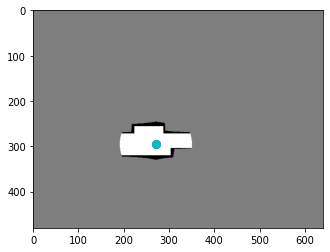

frontier shape [347 272]


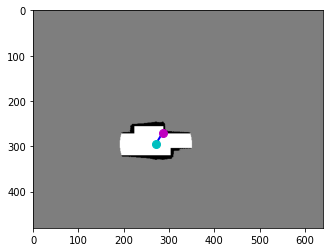

TIMESTEP 1 / ACTION 36 / REWARD -0.8 / Terminal True 

(2, 95)
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 275]
frontier shape [347 274]
frontier shape [347 273]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier sha

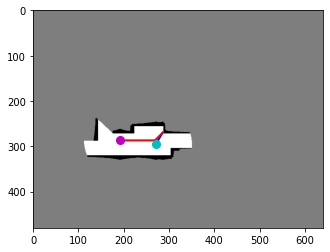

collided??
TIMESTEP 2 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [174 269]


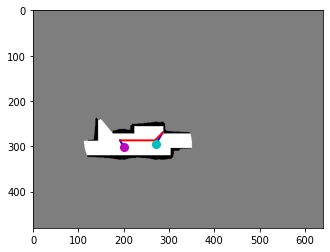

TIMESTEP 3 / ACTION 11 / REWARD -0.8 / Terminal True 

(2, 88)
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier sha

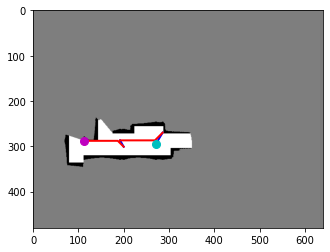

collided??
TIMESTEP 4 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [111 287]


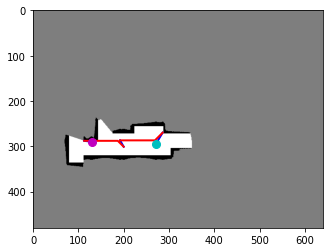

TIMESTEP 5 / ACTION 3 / REWARD -0.8 / Terminal True 

(2, 50)
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shape [347 272]
frontier shap

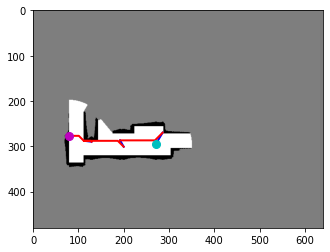

frontier shape [112 223]


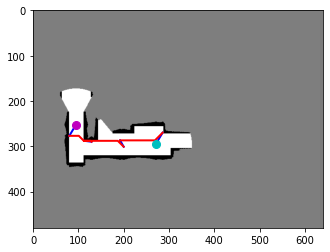

TIMESTEP 6 / ACTION 36 / REWARD 0.2621428571428571 / Terminal False 

frontier shape [112 223]


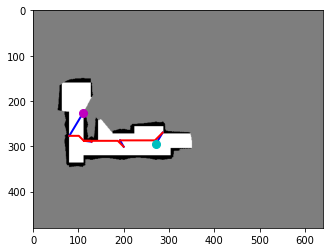

TIMESTEP 7 / ACTION 36 / REWARD 0.16657142857142856 / Terminal False 

collided??
TIMESTEP 8 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [144 191]


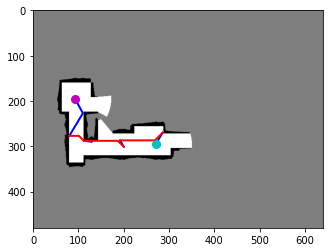

TIMESTEP 9 / ACTION 6 / REWARD 0.2612857142857143 / Terminal False 

frontier shape [144 191]


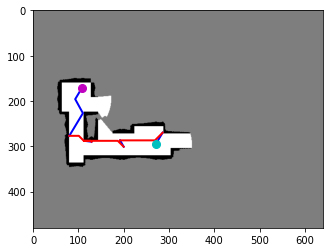

TIMESTEP 10 / ACTION 36 / REWARD -0.8 / Terminal True 

(2, 38)
frontier shape [167 115]
frontier shape [170 116]
frontier shape [170 116]
frontier shape [173 117]
frontier shape [173 117]
frontier shape [173 117]
frontier shape [175 118]
frontier shape [178 119]
frontier shape [178 119]
frontier shape [178 119]
frontier shape [180 120]
frontier shape [182 121]
frontier shape [182 121]
frontier shape [183 122]
frontier shape [185 123]
frontier shape [185 123]
frontier shape [186 124]
frontier shape [188 125]
frontier shape [189 126]
frontier shape [190 126]
frontier shape [191 127]
frontier shape [192 128]
frontier shape [192 128]
frontier shape [193 129]
frontier shape [193 129]
frontier shape [193 129]
frontier shape [193 129]
frontier shape [195 130]
frontier shape [196 131]
frontier shape [195 140]
frontier shape [195 140]
frontier shape [194 141]
frontier shape [194 141]
frontier shape [193 142]
frontier shape [193 142]
frontier shape [192 143]
frontier shape [192 143]
frontier sh

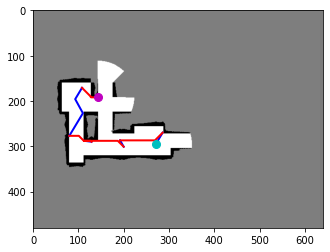

frontier shape [141 158]


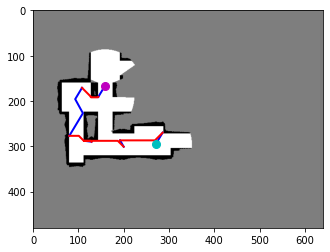

TIMESTEP 11 / ACTION 36 / REWARD 0.4337142857142857 / Terminal False 

frontier shape [186 192]


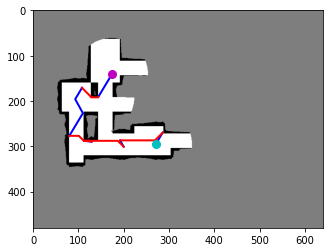

TIMESTEP 12 / ACTION 36 / REWARD 0.4024285714285714 / Terminal False 

frontier shape [259 112]


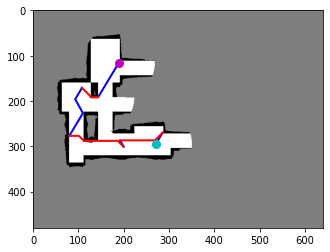

TIMESTEP 13 / ACTION 36 / REWARD 0.09128571428571429 / Terminal False 

collided??
TIMESTEP 14 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [259 112]


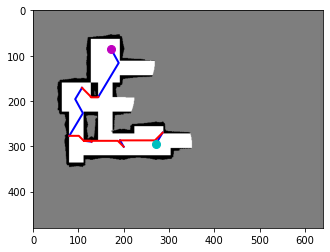

TIMESTEP 15 / ACTION 6 / REWARD -0.8 / Terminal True 

(2, 181)
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier shape [186 192]
frontier sh

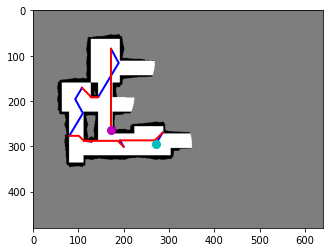

frontier shape [216 223]


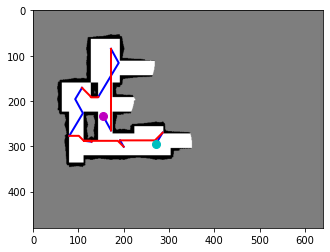

TIMESTEP 16 / ACTION 6 / REWARD -0.8 / Terminal True 

(2, 62)
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [263 143]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier shape [246 223]
frontier sha

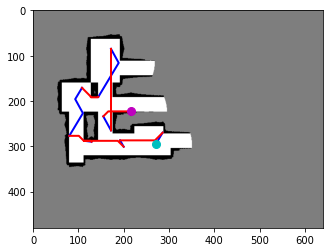

collided??
TIMESTEP 17 / ACTION 11 / REWARD -1 / Terminal False 

frontier shape [272 223]


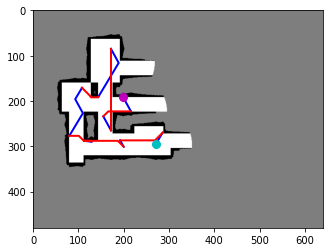

TIMESTEP 18 / ACTION 6 / REWARD -0.8 / Terminal True 

(2, 140)
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier shape [272 223]
frontier sh

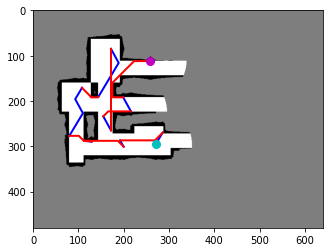

collided??
TIMESTEP 19 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [289 192]


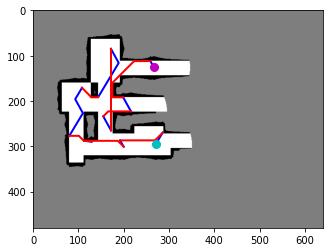

TIMESTEP 20 / ACTION 11 / REWARD 0.04357142857142857 / Terminal False 

collided??
TIMESTEP 21 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 22 / ACTION 6 / REWARD -1 / Terminal False 

frontier shape [289 192]


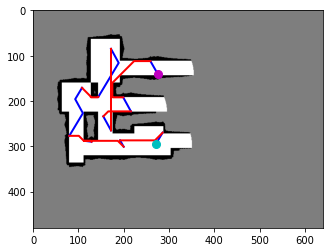

TIMESTEP 23 / ACTION 11 / REWARD 0.032 / Terminal False 

frontier shape [356 112]


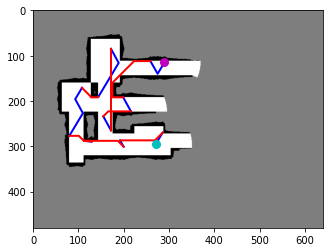

TIMESTEP 24 / ACTION 36 / REWARD 0.07314285714285715 / Terminal False 

collided??
TIMESTEP 25 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 26 / ACTION 6 / REWARD -1 / Terminal False 

frontier shape [353 144]


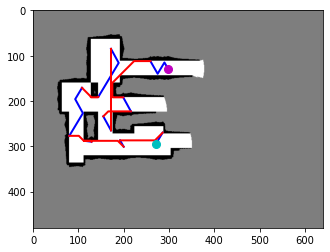

TIMESTEP 27 / ACTION 11 / REWARD 0.05028571428571429 / Terminal False 

collided??
TIMESTEP 28 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 29 / ACTION 6 / REWARD -1 / Terminal False 

frontier shape [353 144]


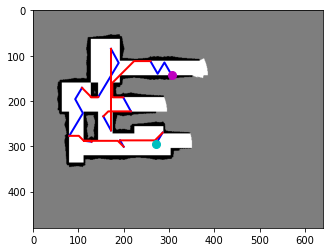

TIMESTEP 30 / ACTION 11 / REWARD 0.03314285714285714 / Terminal False 

frontier shape [353 145]


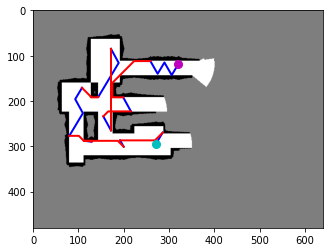

TIMESTEP 31 / ACTION 36 / REWARD 0.15857142857142856 / Terminal False 

collided??
TIMESTEP 32 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 33 / ACTION 6 / REWARD -1 / Terminal False 

frontier shape [353 145]


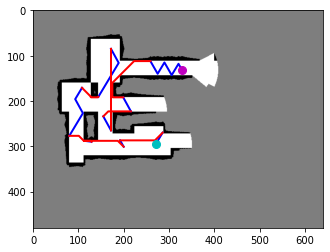

TIMESTEP 34 / ACTION 11 / REWARD 0.10542857142857143 / Terminal False 

collided??
TIMESTEP 35 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 36 / ACTION 6 / REWARD -1 / Terminal False 

collided??
TIMESTEP 37 / ACTION 11 / REWARD -1 / Terminal False 

collided??
TIMESTEP 38 / ACTION 46 / REWARD -1 / Terminal False 

frontier shape [352 171]


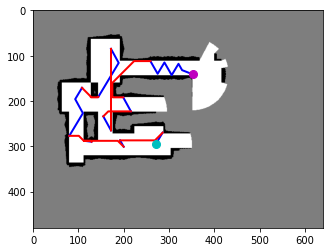

TIMESTEP 39 / ACTION 7 / REWARD 0.6814285714285714 / Terminal False 

frontier shape [369 102]


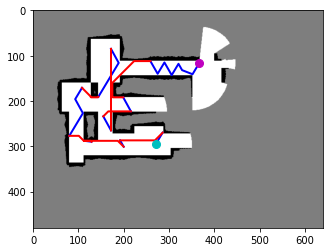

TIMESTEP 40 / ACTION 36 / REWARD 0.3575714285714286 / Terminal False 

frontier shape [416  95]


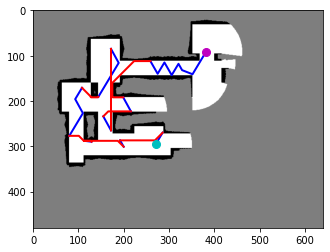

TIMESTEP 41 / ACTION 36 / REWARD 0.5918571428571429 / Terminal False 

frontier shape [417  97]


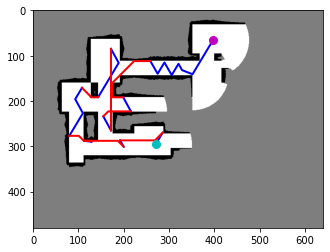

TIMESTEP 42 / ACTION 36 / REWARD 0.28914285714285715 / Terminal False 

frontier shape [417 102]


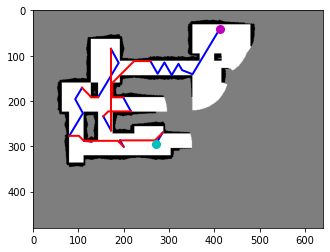

TIMESTEP 43 / ACTION 36 / REWARD 0.04757142857142857 / Terminal False 

collided??
TIMESTEP 44 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 45 / ACTION 6 / REWARD -1 / Terminal False 

frontier shape [482  81]


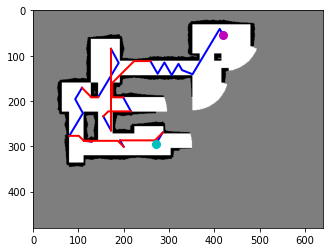

TIMESTEP 46 / ACTION 11 / REWARD 0.097 / Terminal False 

collided??
TIMESTEP 47 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 48 / ACTION 6 / REWARD -1 / Terminal False 

frontier shape [485  81]


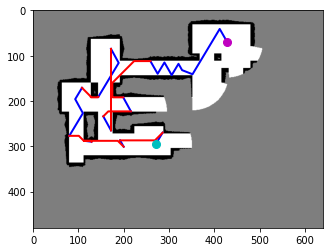

TIMESTEP 49 / ACTION 11 / REWARD 0.16514285714285715 / Terminal False 

frontier shape [485  81]


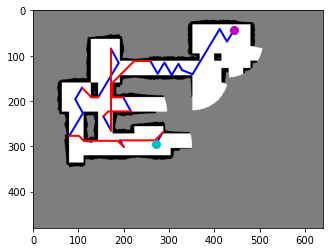

TIMESTEP 50 / ACTION 36 / REWARD -0.8 / Terminal True 

(2, 251)
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [350 303]
frontier shape [302 223]
frontier shape [302 223]
frontier shape [302 223]
frontier shape [302 223]
frontier shape [302 223]
frontier shape [302 223]
frontier shape [302 223]
frontier shape [302 223]
frontier shape [302 223]
frontier shape [302 223]
frontier s

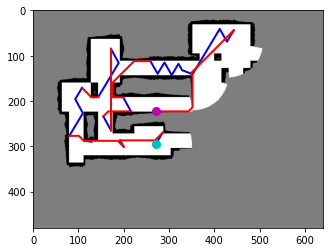

frontier shape [362 222]


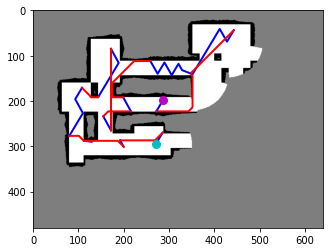

TIMESTEP 51 / ACTION 36 / REWARD -0.8 / Terminal True 

(2, 332)
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier shape [362 223]
frontier s

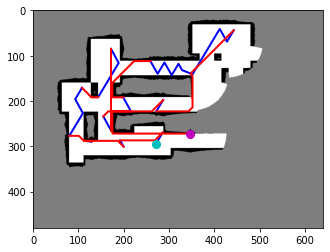

collided??
TIMESTEP 52 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [362 223]


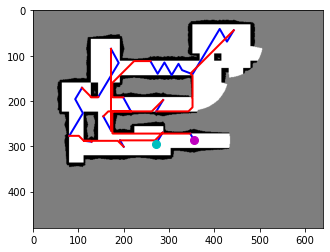

TIMESTEP 53 / ACTION 11 / REWARD 0.04357142857142857 / Terminal False 

collided??
TIMESTEP 54 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 55 / ACTION 6 / REWARD -1 / Terminal False 

collided??
TIMESTEP 56 / ACTION 46 / REWARD -1 / Terminal False 

frontier shape [362 223]


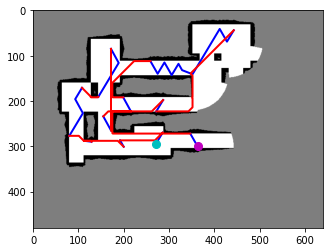

TIMESTEP 57 / ACTION 11 / REWARD 0.032 / Terminal False 

frontier shape [362 223]


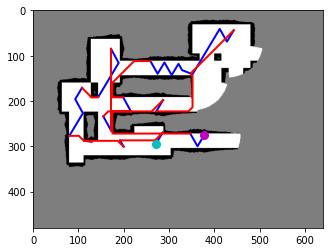

TIMESTEP 58 / ACTION 36 / REWARD 0.06857142857142857 / Terminal False 

collided??
TIMESTEP 59 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [362 223]


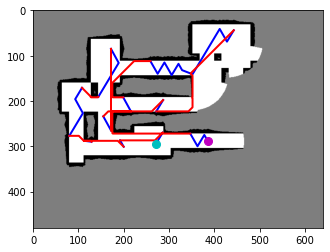

TIMESTEP 60 / ACTION 11 / REWARD 0.04114285714285714 / Terminal False 

collided??
TIMESTEP 61 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [465 303]


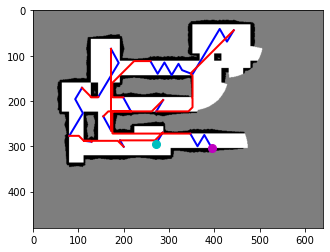

TIMESTEP 62 / ACTION 11 / REWARD 0.02957142857142857 / Terminal False 

frontier shape [381 215]


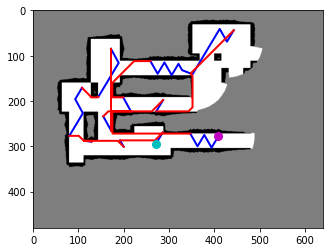

TIMESTEP 63 / ACTION 36 / REWARD 0.07471428571428572 / Terminal False 

collided??
TIMESTEP 64 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [480 304]


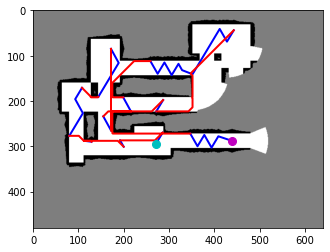

TIMESTEP 65 / ACTION 40 / REWARD 0.213 / Terminal False 

collided??
TIMESTEP 66 / ACTION 36 / REWARD -1 / Terminal False 

frontier shape [480 304]


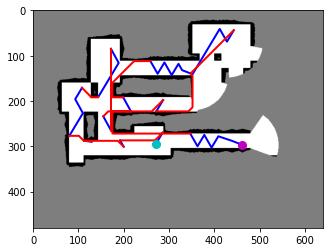

TIMESTEP 67 / ACTION 7 / REWARD 0.30742857142857144 / Terminal False 

frontier shape [481 269]


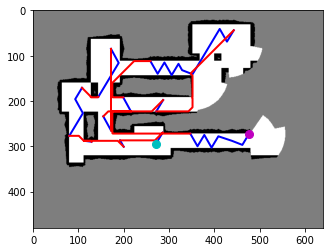

TIMESTEP 68 / ACTION 36 / REWARD 0.16314285714285715 / Terminal False 

collided??
TIMESTEP 69 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 70 / ACTION 6 / REWARD -1 / Terminal False 

frontier shape [513 222]


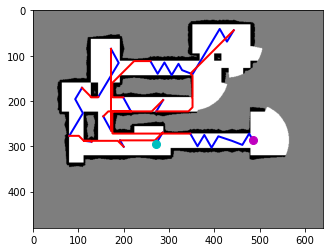

TIMESTEP 71 / ACTION 11 / REWARD 0.37142857142857144 / Terminal False 

frontier shape [513 220]


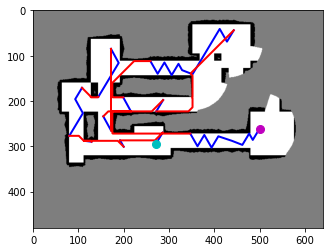

TIMESTEP 72 / ACTION 36 / REWARD 0.3122857142857143 / Terminal False 

frontier shape [512 170]


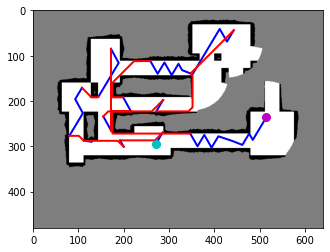

TIMESTEP 73 / ACTION 36 / REWARD 0.17085714285714285 / Terminal False 

frontier shape [521 133]


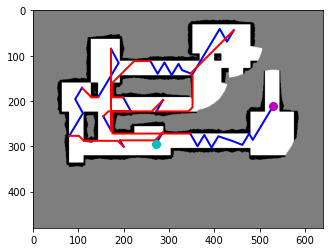

TIMESTEP 74 / ACTION 36 / REWARD 0.11871428571428572 / Terminal False 

collided??
TIMESTEP 75 / ACTION 36 / REWARD -1 / Terminal False 

collided??
TIMESTEP 76 / ACTION 7 / REWARD -1 / Terminal False 

frontier shape [512 130]


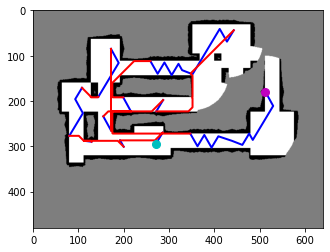

TIMESTEP 77 / ACTION 6 / REWARD 0.1357142857142857 / Terminal False 

frontier shape [511 111]


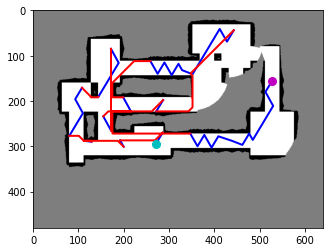

TIMESTEP 78 / ACTION 36 / REWARD 0.13 / Terminal False 

frontier shape [509 110]


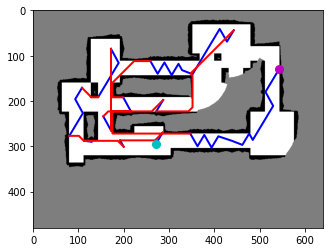

TIMESTEP 79 / ACTION 36 / REWARD -0.8 / Terminal True 

(2, 223)
frontier shape [368 224]


ValueError: ignored

In [3]:
tf.compat.v1.disable_eager_execution()
robot = start()

In [ ]:
remove_outliers = [rew for rew in robot.rewards if rew > -1]
plt.plot(range(len(remove_outliers)), remove_outliers)

In [ ]:
print(robot.rewards)

[]
